In [1]:
import numpy as np
import pandas as pd
import implicit
import matplotlib.pyplot as plt
import matplotlib
from scipy.sparse import csr_matrix
from scipy.linalg import svd
from scipy.sparse.linalg import eigsh
from scipy.stats import spearmanr

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score

import pickle
import heapq
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

from tqdm import tqdm 
import time

from functools import partial
import multiprocessing as mp

from loaders.lastfm import lastfm
from loaders.movielens import movielens
import utils

In [2]:
colors = ["#1b9e77",
          "#d95f02",
          "#7570b3",
          "#e7298a",
          "#66a61e",
          "#e6ab02",
          "#a6761d",
          "#666666" 
         ]

# Load dataset

In [3]:
def get_lastfm():
    lastfm_obj = lastfm(data_dir = "data/lastfm/")
    P = lastfm_obj.filter(min_users = 10, min_ratings = 10)

    P = np.linalg.inv(np.diag(np.sum(P, axis=1))) @ P
    assert np.allclose(np.sum(P, axis=1), np.ones(len(P)))
    return P, lastfm_obj

In [4]:
# PARAMETERS
# Mine which artists see the largest improvement at each interval
P, lastfm_obj = get_lastfm()

is_binary = False
is_normalized = False
if is_binary:
    P[P > 0] = 1 
    
if is_normalized:
    P = P @ np.linalg.inv(np.diag(np.sqrt(np.sum(P, axis = 0))))

P_binary = np.zeros(P.shape)
P_binary[P > 0] = 1

d = P.shape[1]
rs = np.arange(1, d)
print(f"Final shape: {P.shape}")

Shape before filtering:  (1892, 17632)
Shape after filtering:  (1867, 1529)
Final shape: (1867, 1529)


## Generate Teaser

100%|██████████| 1529/1529 [00:13<00:00, 111.90it/s]


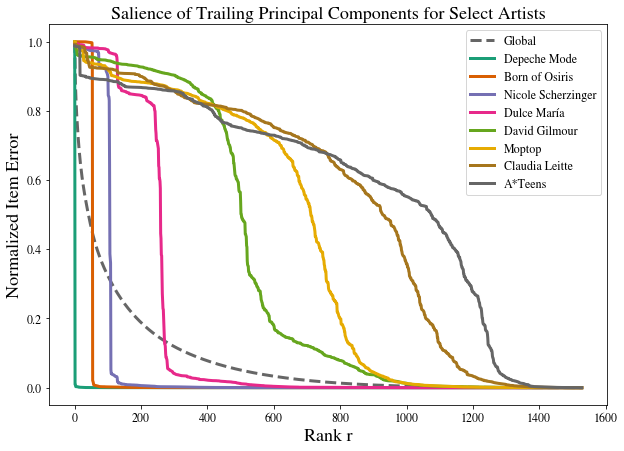

In [5]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

interval_start_idxs = [1, 50, 100, 250, 500, 750, 1000, 1250]
interval_gap = 10

U, S, Vh = svd(P, full_matrices=False)
# assert np.allclose(P, U @ np.diag(S) @ Vh)

plt.rc('font', size=SMALL_SIZE, family = "Nimbus Roman")          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ncols = len(interval_start_idxs)
fig, ax = plt.subplots(figsize = (10, 7))

err = []
proj_mtx = np.zeros((d, d))
for r in np.arange(0, P.shape[1]+1):
    if r > 0:
        proj_mtx += np.outer(Vh[r-1], Vh[r-1])
    P_pred = P @ proj_mtx
    err.append(np.linalg.norm(P - P_pred)**2)

ax.plot(err / np.linalg.norm(P)**2, label = "Global", linewidth = 3, c = colors[-1], linestyle = "--")

for idx, interval_start_idx in enumerate(interval_start_idxs):
    artist_idx = -1
    max_improvement = -1
    
    start_idx = interval_start_idx
    end_idx = interval_start_idx + interval_gap
    
    proj_mtx_start = Vh[:start_idx].T @ Vh[:start_idx]
    proj_mtx_end = Vh[:end_idx].T @ Vh[:end_idx]
#     proj_mtx_start =  proj_matrices_max_pred[start_idx]
#     proj_mtx_end = proj_matrices_max_pred[end_idx]
    
    P_err_start = P - P @ proj_mtx_start
    P_err_end = P - P @ proj_mtx_end
    
    for j in range(P.shape[1]):
        improvement_gap = (np.linalg.norm(P_err_start[:, j])**2 - np.linalg.norm(P_err_end[:, j])**2)\
                            / np.linalg.norm(P[:, j])**2
        if improvement_gap > max_improvement:
            max_improvement = improvement_gap
            artist_idx = j
    
    err = []
    P_pred = np.zeros(P.shape)
    for r in tqdm(np.arange(0, d)):
        P_pred += np.outer(P @ Vh[r], Vh[r])
#         P_pred = P @ proj_matrices_max_pred[r]
        err.append(np.linalg.norm(P[:, artist_idx] - P_pred[:, artist_idx])**2)
        
    ax.plot(err / np.linalg.norm(P[:, artist_idx])**2,
           label = lastfm_obj.convert_artist_idx_to_name(artist_idx),
           c = colors[idx],
           linewidth = 3)
    
ax.set_xlabel("Rank r")
ax.set_ylabel("Normalized Item Error")
ax.set_title("Salience of Trailing Principal Components for Select Artists")
ax.legend()
# plt.savefig(f"figs/salience_of_trailing_components_{is_binary}_{is_normalized}.pdf", bbox_inches = "tight")

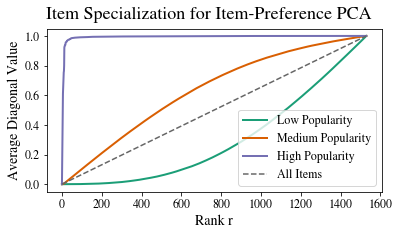

In [6]:
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels

U, S, Vh = np.linalg.svd(P, full_matrices = False)
d = P.shape[1] # should equal len(S)

high_cols, med_cols, low_cols = utils.get_popularity_splits(P)
assert np.all(np.sort(np.concatenate((low_cols, med_cols, high_cols))) == np.arange(d))

fig_diag, ax_diag = plt.subplots(figsize = (6,3))
fig_diag.suptitle("Item Specialization for Item-Preference PCA")

diagonals = np.zeros((len(S)+1, len(S)))
proj_mtx = np.zeros((len(S), len(S)))
for r in range(1,len(S)+1):
    proj_mtx += np.outer(Vh[r-1], Vh[r-1])
    diagonals[r] = np.diagonal(proj_mtx)
ax_diag.plot(range(len(S)+1), np.mean(diagonals[:, low_cols], axis = 1), c = colors[0], linewidth = 2, label="Low Popularity")
ax_diag.plot(range(len(S)+1), np.mean(diagonals[:, med_cols], axis = 1), c = colors[1], linewidth = 2, label="Medium Popularity")
ax_diag.plot(range(len(S)+1), np.mean(diagonals[:, high_cols], axis = 1), c = colors[2], linewidth = 2, label="High Popularity")

ax_diag.plot(range(d+1), np.array(range(d+1))/d, c=colors[-1], linestyle = "--", label="All Items")

#DIAGONALS
#ax_diag.set_title(alg_name)
ax_diag.set_xlabel("Rank r")
ax_diag.set_ylabel("Average Diagonal Value")

ax_diag.legend()

# fig_diag.savefig("figs/lastfm_reliance_on_diagonal.pdf", bbox_inches = "tight")

100%|██████████| 1529/1529 [01:57<00:00, 13.04it/s]


77.74342105263158
455.4582425562818


'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


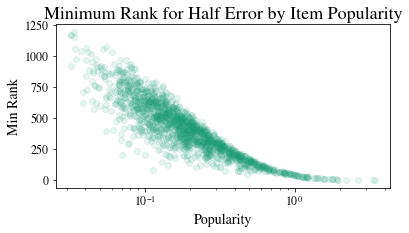

In [9]:
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
# plt.rc('font', fontsize=18)    # fontsize of the x and y labels

fig, ax = plt.subplots(figsize = (6, 3))
ax.set_xscale("log")
ax.set_xlabel("Popularity")
ax.set_ylabel("Min Rank")
ax.set_title("Minimum Rank for Half Error by Item Popularity")

U, S, Vh = np.linalg.svd(P, full_matrices = False)
# err = P - P_pred
# err_normalized = np.linalg.norm(err, axis = 0) / np.linalg.norm(P, axis = 0)
min_ranks_for_half_accuracy = np.zeros(P.shape[1])
P_pred = np.zeros(P.shape)
for r in tqdm(range(1, d+1)):
    P_pred += np.outer(P @ Vh[r-1], Vh[r-1])
    for j in range(P.shape[1]):
        norm_err = np.linalg.norm(P[:, j] - P_pred[:, j])**2 / np.linalg.norm(P[:, j])**2
        if min_ranks_for_half_accuracy[j] == 0 and norm_err <= 0.5:
            min_ranks_for_half_accuracy[j] = r
            
popularities = np.linalg.norm(P, axis = 0)
ax.scatter(x = popularities, y = min_ranks_for_half_accuracy, c = colors[0], alpha = 0.1, label = "Vanilla")

# P_pred = P @ proj_matrices_max_pred[r]
# err = P - P_pred
# err_normalized = np.linalg.norm(err, axis = 0) / np.linalg.norm(P, axis = 0)
# ax.scatter(x = popularities, y = err_normalized, c = colors[1], alpha = 0.4, label = "Max Prediction")

#ax.set_yscale("log")
# ax.legend()

num_head = int(0.1 * P.shape[1])
top_popularities_idx = np.argsort(popularities)
print(np.mean(min_ranks_for_half_accuracy[top_popularities_idx[-num_head:]]))
print(np.mean(min_ranks_for_half_accuracy[top_popularities_idx[:-num_head]]))

fig.savefig("figs/top_artist_specialization.pdf", bbox_inches = "tight")
